In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmcrameri import cm


In [2]:
PROJECTION = ccrs.PlateCarree()


def prep_axes(ax, extents=[-125, -65, 22, 58], grid=False):
    ax.set_extent(extents, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), edgecolor="gray", zorder=2)
    ax.spines[:].set_color("gray")
    if grid:
        gl = ax.gridlines(
            crs=PROJECTION,
            linewidth=0.8,
            color="gray",
            alpha=0.5,
            linestyle="--",
            draw_labels=True,
            zorder=0,
        )
        gl.top_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.right_labels = False
        gl.xlines = True
        gl.ylines = True
        # gl.xlocator = mticker.FixedLocator([-120, -100, -80])
        gl.ylocator = mticker.FixedLocator([30, 40, 50])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return ax


In [2]:
format_time = lambda ds: ds.expand_dims(month=[pd.to_datetime(ds["time"].data)], axis=-1)
ds_predictions = xr.open_mfdataset(
    "../data/production/models/*/cokriging_results.nc4", preprocess=format_time
)
ds_predictions


<xarray.Dataset>
Dimensions:               (month: 1, lat: 720, lon: 1200)
Coordinates:
  * month                 (month) datetime64[ns] 2021-07-01
  * lat                   (lat) float64 22.02 22.07 22.12 ... 57.87 57.92 57.97
  * lon                   (lon) float64 -125.0 -124.9 -124.9 ... -65.07 -65.02
    time                  object ...
Data variables: (12/65)
    residual_predictions  (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    prediction_error      (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    validity_flag         (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    B2                    (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    B3                    (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    B4                    (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    ...                    ...
    B60                   (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    trend_surface         (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    predictions           (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    mspe                  (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    scaled_residuals      (lat, lon, month) float64 dask.array<chunksize=(720, 1200, 1), meta=np.ndarray>
    trend_surface_mspe    (month) float64 0.06159
Attributes:
    timedeltas:        [0 1]
    num_local_values:  150

In [3]:
with xr.open_dataset("../data/production/OCO2_005deg_monthly_north_america_with_basis.nc4") as ds:
    ds_data = ds.rename(time="month").sel(month=ds_predictions.month)

ds_data


<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1200, month: 1)
Coordinates:
  * lat       (lat) float64 22.02 22.07 22.12 22.17 ... 57.82 57.87 57.92 57.97
  * lon       (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.12 -65.07 -65.02
  * month     (month) datetime64[ns] 2021-07-01
    time      object ...
Data variables: (12/64)
    sif       (lat, lon, month) float32 ...
    sif_var   (lat, lon, month) float32 ...
    xco2      (lat, lon, month) float32 ...
    xco2_var  (lat, lon, month) float32 ...
    B1        (lat, lon) float64 ...
    B2        (lat, lon) float64 ...
    ...        ...
    B55       (lat, lon) float64 ...
    B56       (lat, lon) float64 ...
    B57       (lat, lon) float64 ...
    B58       (lat, lon) float64 ...
    B59       (lat, lon) float64 ...
    B60       (lat, lon) float64 ...

## Map the predicitons and prediction std error

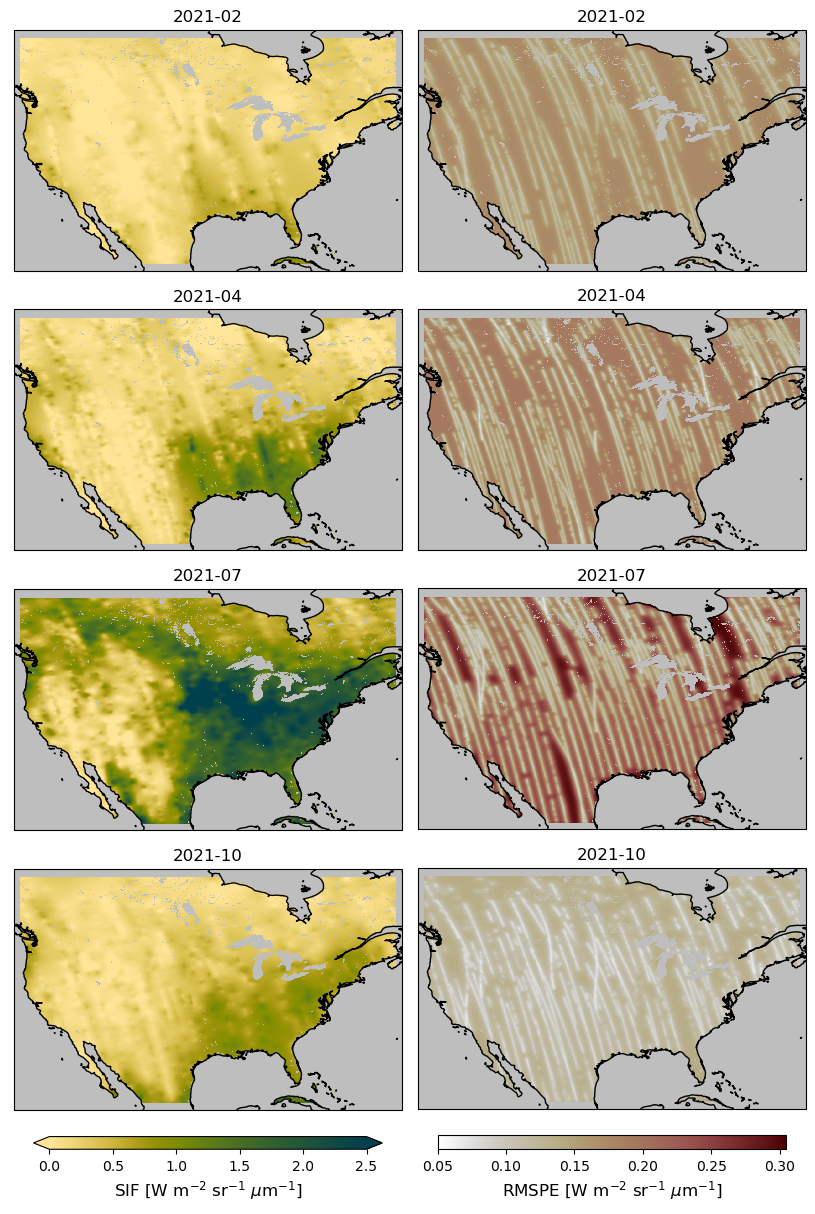

In [5]:
months = ["2021-02", "2021-04", "2021-07", "2021-10"]

fig = plt.figure(figsize=(8, 12), constrained_layout=True)
subfigs = fig.subfigures(1, 2)

axes_left = subfigs[0].subplots(4, 1, subplot_kw={"projection": PROJECTION})
axes_right = subfigs[1].subplots(4, 1, subplot_kw={"projection": PROJECTION})

# plot predictions
for i, month in enumerate(ds_predictions["month"].data):
    ds_month = ds_predictions.sel(month=month)
    ax0 = prep_axes(axes_left[i])
    ax1 = prep_axes(axes_right[i])

    field_prediction = xr.plot.imshow(
        darray=ds_month["predictions"],
        transform=PROJECTION,
        ax=ax0,
        cmap=cm.bamako_r,
        vmin=0,
        vmax=2.5,
        add_colorbar=False,
        add_labels=False,
    )
    ax0.set_title(months[i], fontsize=12)

    field_error = xr.plot.imshow(
        darray=np.sqrt(ds_month["mspe"]),
        transform=PROJECTION,
        ax=ax1,
        cmap=cm.bilbao,
        vmin=0.05,
        vmax=0.305,
        add_colorbar=False,
        add_labels=False,
    )
    ax1.set_title(months[i], fontsize=12)

subfigs[0].colorbar(
    field_prediction,
    ax=axes_left,
    location="bottom",
    orientation="horizontal",
    extend="both",
    panchor=False,
    shrink=0.9,
    aspect=25,
    pad=0.015,
).set_label(label="SIF [W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$]", fontsize=12)

subfigs[1].colorbar(
    field_error,
    ax=axes_right,
    location="bottom",
    orientation="horizontal",
    # extend="both",
    panchor=False,
    shrink=0.9,
    aspect=25,
    pad=0.015,
).set_label(label="RMSPE [W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$]", fontsize=12)


In [6]:
fig.savefig("../figures/cokriging_results.pdf", dpi=300)


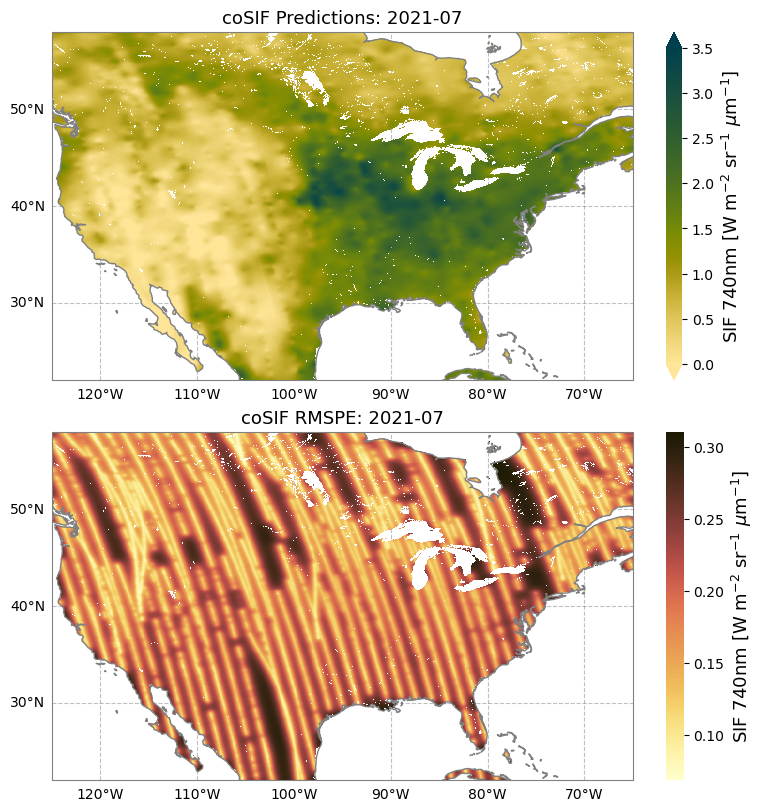

In [5]:
extents = [-125, -65, 22, 58]
SIF_UNITS = "740nm [W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$]"

fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), subplot_kw={"projection": PROJECTION}, constrained_layout=True
)

prep_axes(axes[0], extents=extents, grid=True)
field_prediction = xr.plot.imshow(
    darray=ds_predictions.sel(month="2021-07").squeeze()["predictions"],
    zorder=1,
    transform=ccrs.PlateCarree(),
    ax=axes[0],
    cmap=cm.bamako_r,
    vmin=0,
    vmax=3.5,
    add_colorbar=False,
    add_labels=False,
)
axes[0].set_title("coSIF Predictions: 2021-07", fontsize=13)
cb1 = fig.colorbar(field_prediction, ax=axes[0], extend="both")
cb1.set_label(label=f"SIF {SIF_UNITS}", fontsize=13)
cb1.outline.set_visible(False)

prep_axes(axes[1], extents=extents, grid=True)
field_error = xr.plot.imshow(
    darray=np.sqrt(ds_predictions.sel(month="2021-07").squeeze()["mspe"]),
    zorder=1,
    transform=ccrs.PlateCarree(),
    ax=axes[1],
    cmap=cm.lajolla,
    # vmin=0.05,
    # vmax=0.305,
    add_colorbar=False,
    add_labels=False,
)
axes[1].set_title("coSIF RMSPE: 2021-07", fontsize=13)
cb2 = fig.colorbar(field_error, ax=axes[1])
cb2.set_label(label=f"SIF {SIF_UNITS}", fontsize=13)
cb2.outline.set_visible(False)


In [6]:
fig.savefig("../figures/cokriging_results_202107.pdf", dpi=300, bbox_inches="tight")


## Calculate average standard error ratios

In [4]:
# NOTE: groupby month when we have all predictions again

# NOTE: "sif_var" is a misnomer, it is actually the standard error
df_se = (
    xr.merge([ds_predictions["mspe"], ds_data["sif_var"]])
    .squeeze()
    .astype(np.float64)
    .to_dataframe()
    .reset_index()
    .drop(columns=["month", "time"])
    .dropna(subset="sif_var")
)
df_se["rmspe"] = np.sqrt(df_se["mspe"])
df_se["se_ratio"] = df_se["rmspe"] / df_se["sif_var"]
df_se["se_ratio"].mean()


0.2587963542323123

<AxesSubplot:ylabel='Frequency'>

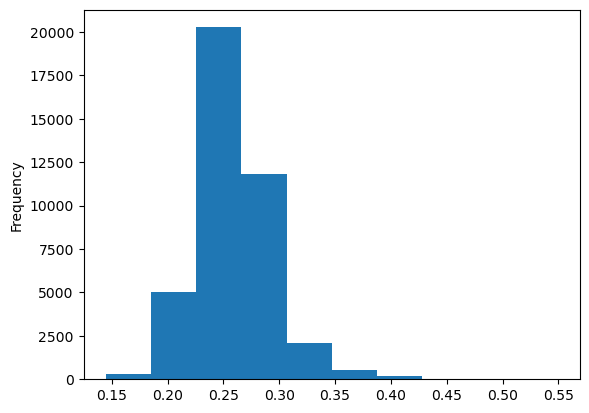

In [5]:
df_se["se_ratio"].plot(kind="hist")
